**# Tire Degradation Prediction in Formula 1

## Objective
This project aims to predict tire degradation in Formula 1 races by modeling the **TyreDegRate** (change in lap time per lap within a stint, in seconds) using lap-by-lap data from the 2024 Bahrain Grand Prix. The goal is to understand how tire wear affects performance, considering factors like tire compound, tyre life, sector times, track conditions, and driver behavior.**

In [19]:
!pip install pandas numpy scikit-learn matplotlib seaborn fastf1  xgboost tensorflow keras


**enable caching to speed up requests**

In [20]:
import os

# Create the cache directory if it doesn't exist
cache_dir = "f1_cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

import fastf1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Enable caching
fastf1.Cache.enable_cache(cache_dir)


**Load Race Data (Lap-by-Lap)**

In [21]:
# Load race session
race = fastf1.get_session(2024, "Bahrain Grand Prix", "R")

# Load all data
race.load()

laps_df = race.laps
# Display available data columns
print(race.laps.columns)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')


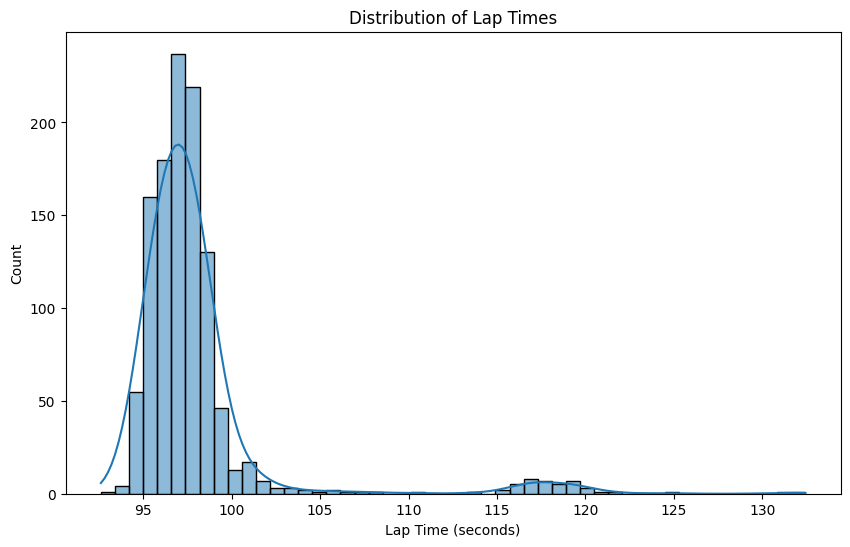

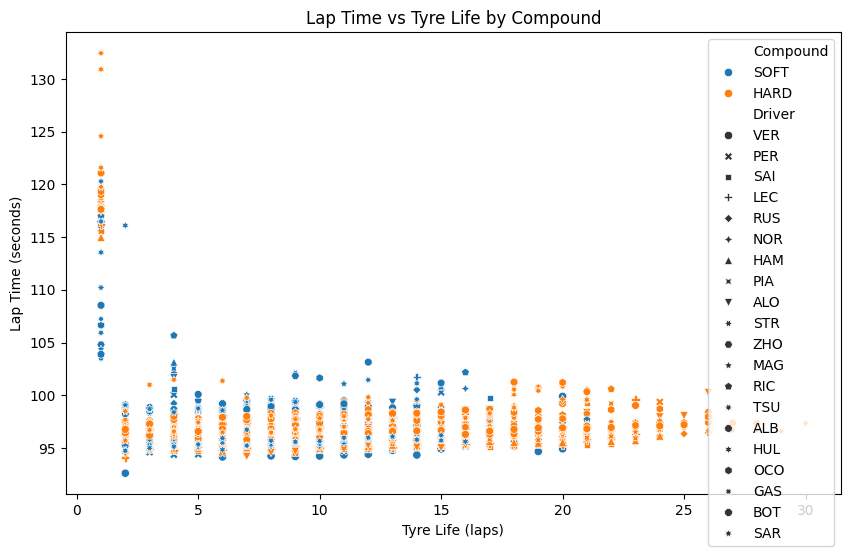

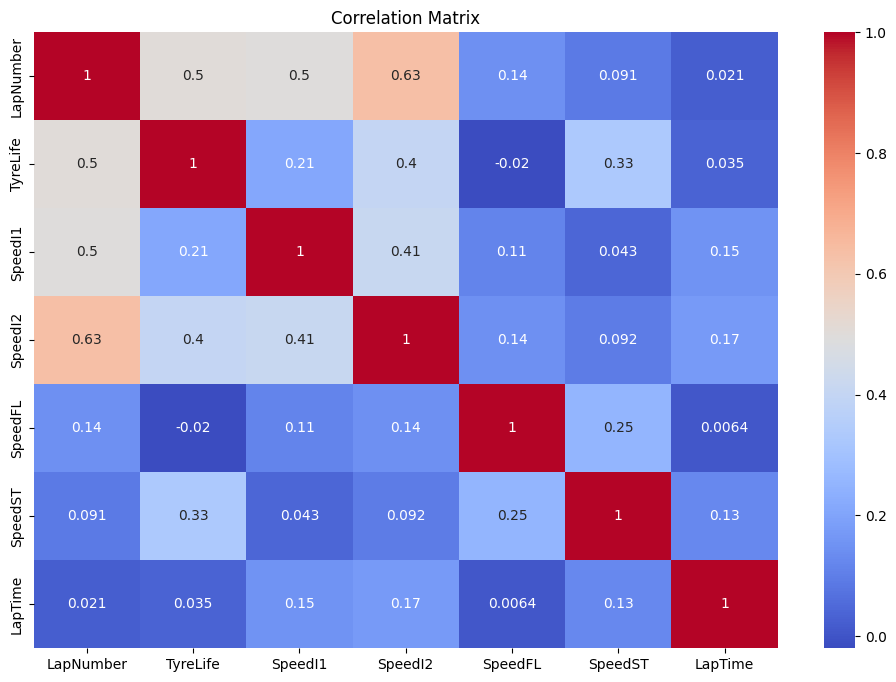

Number of outliers: 43


In [22]:
# Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of LapTime
plt.figure(figsize=(10, 6))
sns.histplot(laps_df['LapTime'].dt.total_seconds(), bins=50, kde=True)
plt.title('Distribution of Lap Times')
plt.xlabel('Lap Time (seconds)')
plt.show()

# LapTime vs TyreLife by Compound
plt.figure(figsize=(10, 6))
sns.scatterplot(data=laps_df, x='TyreLife', y=laps_df['LapTime'].dt.total_seconds(), hue='Compound', style='Driver')
plt.title('Lap Time vs Tyre Life by Compound')
plt.xlabel('Tyre Life (laps)')
plt.ylabel('Lap Time (seconds)')
plt.show()

# Correlation matrix
numeric_cols = ['LapNumber', 'TyreLife', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'LapTime']
laps_df['LapTime (s)'] = laps_df['LapTime'].dt.total_seconds()
plt.figure(figsize=(12, 8))
sns.heatmap(laps_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Check for outliers in LapTime
laps_df['LapTime_zscore'] = (laps_df['LapTime (s)'] - laps_df['LapTime (s)'].mean()) / laps_df['LapTime (s)'].std()
outliers = laps_df[abs(laps_df['LapTime_zscore']) > 3]
print(f"Number of outliers: {len(outliers)}")
laps_df = laps_df[abs(laps_df['LapTime_zscore']) <= 3].drop(columns=['LapTime_zscore'])

**Extract Tire Degradation Data**

In [23]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Select relevant columns
tire_data = laps_df[['Driver', 'LapNumber', 'Stint', 'Compound', 'TyreLife', 'FreshTyre', 'LapTime',
                     'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL',
                     'SpeedST', 'TrackStatus', 'Time']].copy()

# Convert times to seconds
tire_data['LapTime (s)'] = tire_data['LapTime'].dt.total_seconds()
tire_data['Sector1Time'] = tire_data['Sector1Time'].dt.total_seconds()
tire_data['Sector2Time'] = tire_data['Sector2Time'].dt.total_seconds()
tire_data['Sector3Time'] = tire_data['Sector3Time'].dt.total_seconds()

# Define target: TyreDegRate (change in lap time per lap within a stint)
tire_data['TyreDegRate'] = tire_data.groupby(['Driver', 'Stint'])['LapTime (s)'].diff().fillna(0)

# Encode categorical variables
le_compound = LabelEncoder()
tire_data['Compound'] = le_compound.fit_transform(tire_data['Compound'])
tire_data['TrackStatus'] = tire_data['TrackStatus'].astype('category').cat.codes
tire_data['FreshTyre'] = tire_data['FreshTyre'].astype(int)

# Impute missing values for numeric columns
numeric_cols = ['LapNumber', 'TyreLife', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
                'Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime (s)']
imputer = SimpleImputer(strategy='median')
tire_data[numeric_cols] = imputer.fit_transform(tire_data[numeric_cols])

# Check for remaining NaNs
if tire_data[numeric_cols].isna().any().any():
    print("Warning: NaNs found in numeric columns after imputation")
else:
    print("No NaNs in numeric columns after imputation")

# Display processed data
print(tire_data.head())
print(tire_data.columns)

No NaNs in numeric columns after imputation
  Driver  LapNumber  Stint  Compound  TyreLife  FreshTyre  \
0    VER        1.0    1.0         1       4.0          0   
1    VER        2.0    1.0         1       5.0          0   
2    VER        3.0    1.0         1       6.0          0   
3    VER        4.0    1.0         1       7.0          0   
4    VER        5.0    1.0         1       8.0          0   

                 LapTime  Sector1Time  Sector2Time  Sector3Time  SpeedI1  \
0 0 days 00:01:37.284000       30.938       41.266       23.616    234.0   
1 0 days 00:01:36.296000       30.916       41.661       23.719    232.0   
2 0 days 00:01:36.753000       30.999       41.966       23.788    231.0   
3 0 days 00:01:36.647000       30.931       41.892       23.824    233.0   
4 0 days 00:01:37.173000       31.255       42.056       23.862    231.0   

   SpeedI2  SpeedFL  SpeedST  TrackStatus                   Time  LapTime (s)  \
0    250.0    276.0    251.0            1 0 days 01

In [27]:
# Feature Engineering
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Domain-specific features
tire_data['StintLength'] = tire_data.groupby(['Driver', 'Stint'])['LapNumber'].transform('count')
tire_data['CumulativeDistance'] = tire_data['TyreLife'] * 5.412  # Bahrain track length ~5.412 km
tire_data['DriverAggressiveness'] = tire_data['SpeedST'] / tire_data['SpeedST'].mean()

# Merge weather data
weather_data = race.weather_data
print("Weather data shape:", weather_data.shape)
print("Weather data Time range:", weather_data['Time'].min(), "to", weather_data['Time'].max())
print("tire_data Time range:", tire_data['Time'].min(), "to", tire_data['Time'].max())
print("Weather data columns:", weather_data.columns.tolist())
print("Weather data sample:\n", weather_data[['Time', 'AirTemp', 'TrackTemp']].head())

# Perform nearest-time merge
tire_data_sorted = tire_data.sort_values('Time')
weather_data_sorted = weather_data[['Time', 'AirTemp', 'TrackTemp']].sort_values('Time')
tire_data = pd.merge_asof(
    tire_data_sorted,
    weather_data_sorted,
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta('5min'),
    allow_exact_matches=True
)

# Check columns after merge
print("tire_data columns after merge:", tire_data.columns.tolist())

# Initialize AirTemp and TrackTemp if missing
if 'AirTemp' not in tire_data.columns or 'TrackTemp' not in tire_data.columns:
    print("Warning: AirTemp or TrackTemp missing after merge, initializing with fallback values")
    tire_data['AirTemp'] = 25.0  # Typical air temp in Bahrain (°C)
    tire_data['TrackTemp'] = 35.0  # Typical track temp in Bahrain (°C)

# Check merge success
print("NaN counts after merge:\n", tire_data[['AirTemp', 'TrackTemp']].isna().sum())
if tire_data['AirTemp'].isna().all() or tire_data['TrackTemp'].isna().all():
    print("Warning: Weather data merge failed, using fallback values")
    tire_data['AirTemp'] = tire_data['AirTemp'].fillna(25.0)
    tire_data['TrackTemp'] = tire_data['TrackTemp'].fillna(35.0)
else:
    # Impute remaining NaNs with median
    imputer_weather = SimpleImputer(strategy='median')
    tire_data[['AirTemp', 'TrackTemp']] = imputer_weather.fit_transform(tire_data[['AirTemp', 'TrackTemp']])

# Interaction feature
tire_data['Compound_TrackTemp'] = tire_data['Compound'] * tire_data['TrackTemp']

# Lagged features
tire_data['PrevLapTime'] = tire_data.groupby('Driver')['LapTime (s)'].shift(1).fillna(tire_data['LapTime (s)'].mean())
tire_data['PrevSpeedST'] = tire_data.groupby('Driver')['SpeedST'].shift(1).fillna(tire_data['SpeedST'].mean())

# Additional features
tire_data['TireLoadIndex'] = (tire_data['SpeedI1'] + tire_data['SpeedI2']) / (tire_data['SpeedST'] + 1e-6)
tire_data['SectorTimeStd'] = tire_data[['Sector1Time', 'Sector2Time', 'Sector3Time']].std(axis=1)
tire_data['PostPitLap'] = (tire_data['LapNumber'].diff() < 0).astype(int)

# Improved TyreWearFactor and TyreWearRate
tire_data['TyreWearFactor'] = tire_data['TyreLife'] / np.log(tire_data['LapNumber'] + 2)
tire_data['TyreWearRate'] = tire_data['TyreWearFactor'] / (tire_data['SpeedST'] + 1e-6)

# Impute derived features
derived_cols = ['StintLength', 'CumulativeDistance', 'DriverAggressiveness', 'Compound_TrackTemp',
                'PrevLapTime', 'PrevSpeedST', 'TireLoadIndex', 'SectorTimeStd', 'PostPitLap',
                'TyreWearFactor', 'TyreWearRate']
imputer_derived = SimpleImputer(strategy='median')
tire_data[derived_cols] = imputer_derived.fit_transform(tire_data[derived_cols])

# Define features
features = ['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'TrackStatus', 'FreshTyre', 'Compound', 'StintLength', 'CumulativeDistance', 'DriverAggressiveness',
            'AirTemp', 'TrackTemp', 'Compound_TrackTemp', 'PrevLapTime', 'PrevSpeedST', 'TireLoadIndex',
            'SectorTimeStd', 'PostPitLap', 'TyreWearFactor', 'TyreWearRate']

# Check for NaNs in features
if tire_data[features].isna().any().any():
    print("Warning: NaNs found in features after feature engineering")
    print(tire_data[features].isna().sum())
else:
    print("No NaNs in features after feature engineering")

# Drop rows with invalid target
tire_data = tire_data.dropna(subset=['TyreDegRate'])

# Display feature info
print("Features:", features)
print(tire_data[features].head())

Weather data shape: (157, 8)
Weather data Time range: 0 days 00:00:14.093000 to 0 days 02:36:14.319000
tire_data Time range: 0 days 01:01:37.489000 to 0 days 02:33:18.163000
Weather data columns: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Weather data sample:
                     Time  AirTemp  TrackTemp
0 0 days 00:00:14.093000     18.9       26.5
1 0 days 00:01:14.084000     18.9       26.5
2 0 days 00:02:14.093000     18.9       26.5
3 0 days 00:03:14.090000     18.9       26.2
4 0 days 00:04:14.091000     18.9       26.2
tire_data columns after merge: ['Driver', 'LapNumber', 'Stint', 'Compound', 'TyreLife', 'FreshTyre', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TrackStatus', 'Time', 'LapTime (s)', 'TyreDegRate', 'StintLength', 'CumulativeDistance', 'DriverAggressiveness', 'AirTemp_x', 'TrackTemp_x', 'AirTemp_y', 'TrackTemp_y', 'AirTemp', 'TrackTemp']
NaN counts after m

**Data Splitting**

In [28]:
# Data Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
X = tire_data[features]
y = tire_data['TyreDegRate']

# Check for NaNs in X
if X.isna().any().any():
    print("Warning: NaNs found in X before splitting")
    print(X.isna().sum())
    # Drop rows with NaNs
    valid_idx = X.notna().all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    print(f"Dropped {len(tire_data) - len(X)} rows with NaNs")

# Time-based split
tire_data_sorted = tire_data.loc[X.index].sort_values(by=['Driver', 'LapNumber'])
train_size = int(0.8 * len(tire_data_sorted))
X_train = tire_data_sorted.iloc[:train_size][features]
y_train = tire_data_sorted.iloc[:train_size]['TyreDegRate']
X_test = tire_data_sorted.iloc[train_size:][features]
y_test = tire_data_sorted.iloc[train_size:]['TyreDegRate']

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Check for NaNs in scaled data
if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any() or np.isnan(X_val_scaled).any():
    print("Warning: NaNs found in scaled data")
else:
    print("No NaNs in scaled data")

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

No NaNs in scaled data
Training set shape: (693, 24)
Validation set shape: (174, 24)
Test set shape: (217, 24)


**Model Comparison**

In [29]:
# Model Comparison
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

# Install missing dependencies
!pip install lightgbm catboost

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        mae_val = mean_absolute_error(y_val, y_val_pred)
        rmse_val = mean_squared_error(y_val, y_val_pred) ** 0.5
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
        results[name] = {
            'Val MAE': mae_val,
            'Val RMSE': rmse_val,
            'CV MAE': -cv_scores.mean(),
            'CV MAE Std': cv_scores.std() * 2
        }
        print(f"{name} - Val MAE: {mae_val:.4f}, Val RMSE: {rmse_val:.4f}, CV MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except ValueError as e:
        print(f"Error training {name}: {e}")
        continue

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

LinearRegression - Val MAE: 0.3495, Val RMSE: 0.6494, CV MAE: 0.3463 (+/- 0.0611)
RandomForest - Val MAE: 0.1969, Val RMSE: 0.4592, CV MAE: 0.2439 (+/- 0.0731)
GradientBoosting - Val MAE: 0.1934, Val RMSE: 0.4124, CV MAE: 0.2192 (+/- 0.0495)
SVR - Val MAE: 0.2717, Val RMSE: 0.7275, CV MAE: 0.2526 (+/- 0.0811)
XGBoost - Val MAE: 0.1784, Val RMSE: 0.4218, CV MAE: 0.1936 (+/- 0.0627)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 693, number of used features: 24
[LightGBM] [Info] Start training from score 0.041722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost - Val MAE: 0.1592, Val RMSE: 0.3788, CV MAE: 0.1556 (+/- 0.0408)
MLP - Val MAE: 0.1526, Val RMSE: 0.3282, CV MAE: 0.1573 (+/- 0.0287)

Model Comparison:
                    Val MAE  Val RMSE    CV MAE  CV MAE Std
LinearRegression  0.349533  0.649395  0.346312    0.061112
RandomForest      0.196885  0.459237  0.243852    0.073111
GradientBoosting  0.193426  0.412418  0.219150    0.049452
SVR               0.271707  0.727469  0.252580    0.081129
XGBoost           0.178386  0.421791  0.193576    0.062745
LightGBM          0.221517  0.534776  0.224947    0.070604
CatBoost          0.159168  0.378794  0.155593    0.040788
MLP               0.152629  0.328204  0.157288    0.028686


**Hyperparameter Tuning**

In [34]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Ensure models dictionary exists (from Cell 10)
if 'models' not in globals():
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'LightGBM': LGBMRegressor(random_state=42),
        'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
        'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    }

# Define parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'SVR': {
        'kernel': ['rbf'],
        'C': [1, 10],
        'epsilon': [0.01, 0.1]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(100, 50), (50, 50)],
        'alpha': [0.0001, 0.001],
        'max_iter': [1000]
    }
}

# Tune models
best_models = {}
best_params = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    try:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_models[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
        print(f"Best {name} Params: {grid.best_params_}")
        print(f"Best {name} CV MAE: {-grid.best_score_:.4f}\n")
    except Exception as e:
        print(f"Error tuning {name}: {e}")
        continue

# Verify best_params
print("Best parameters saved:", best_params)

Tuning LinearRegression...
Error tuning LinearRegression: 'LinearRegression'
Tuning RandomForest...
Best RandomForest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best RandomForest CV MAE: 0.2383

Tuning GradientBoosting...
Best GradientBoosting Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best GradientBoosting CV MAE: 0.1855

Tuning SVR...
Best SVR Params: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
Best SVR CV MAE: 0.1472

Tuning XGBoost...
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best XGBoost CV MAE: 0.1853

Tuning LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 693, number of used features: 24
[LightGBM] [Info] Start training from score 0.041722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

**Model Evaluation**

RandomForest - Test MAE: 0.2405, Test RMSE: 0.6391
GradientBoosting - Test MAE: 0.1721, Test RMSE: 0.5458
SVR - Test MAE: 0.1770, Test RMSE: 0.5699
XGBoost - Test MAE: 0.1717, Test RMSE: 0.5180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2216
[LightGBM] [Info] Number of data points in the train set: 693, number of used features: 24
[LightGBM] [Info] Start training from score 0.041722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost - Test MAE: 0.1874, Test RMSE: 0.5720
MLP - Test MAE: 0.1705, Test RMSE: 0.3809

Test Set Results:
                   Test MAE  Test RMSE
RandomForest      0.240472   0.639113
GradientBoosting  0.172055   0.545842
SVR               0.176973   0.569938
XGBoost           0.171694   0.518020
LightGBM          0.204808   0.545643
CatBoost          0.187446   0.572007
MLP               0.170529   0.380910

Best Model: MLP with Test MAE: 0.1705


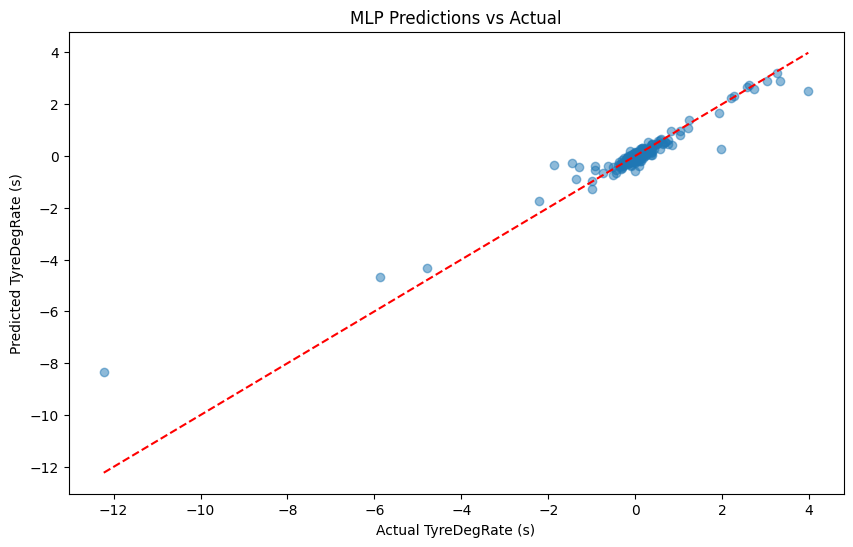

In [35]:
# Model Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Check if best_params exists
if 'best_params' not in globals():
    raise NameError("best_params not defined. Please run Cell 11 (Hyperparameter Tuning) first.")

# Dictionary of tuned models (from Cell 11)
tuned_models = {
    'RandomForest': RandomForestRegressor(**best_params['RandomForest'], random_state=42),
    'GradientBoosting': GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=42),
    'SVR': SVR(**best_params['SVR']),
    'XGBoost': xgb.XGBRegressor(**best_params['XGBoost'], objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(**best_params['LightGBM'], random_state=42),
    'CatBoost': CatBoostRegressor(**best_params['CatBoost'], verbose=0, random_state=42),
    'MLP': MLPRegressor(**best_params['MLP'], random_state=42)
}

# Evaluate on test set
test_results = {}
for name, model in tuned_models.items():
    try:
        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5
        test_results[name] = {'Test MAE': mae_test, 'Test RMSE': rmse_test}
        print(f"{name} - Test MAE: {mae_test:.4f}, Test RMSE: {rmse_test:.4f}")
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        continue

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("\nTest Set Results:\n", test_results_df)

# Select best model
best_model_name = test_results_df['Test MAE'].idxmin()
best_model = tuned_models[best_model_name]
print(f"\nBest Model: {best_model_name} with Test MAE: {test_results_df.loc[best_model_name, 'Test MAE']:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
y_test_pred = best_model.predict(X_test_scaled)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual TyreDegRate (s)')
plt.ylabel('Predicted TyreDegRate (s)')
plt.title(f'{best_model_name} Predictions vs Actual')
plt.show()

**Model Interpretability**

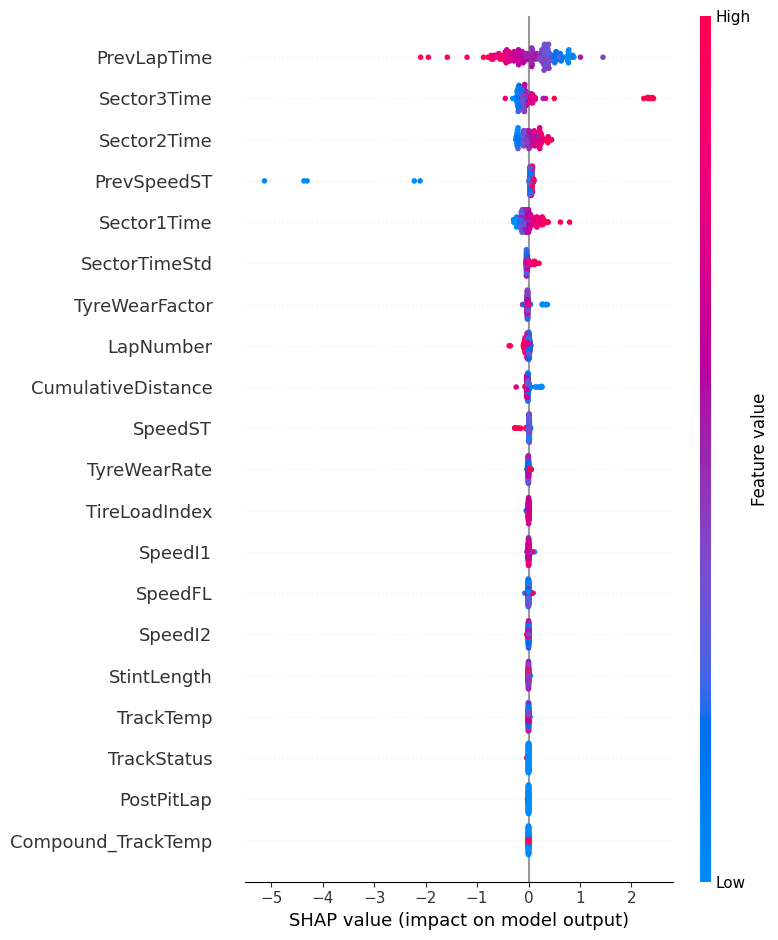

<Figure size 1200x800 with 0 Axes>

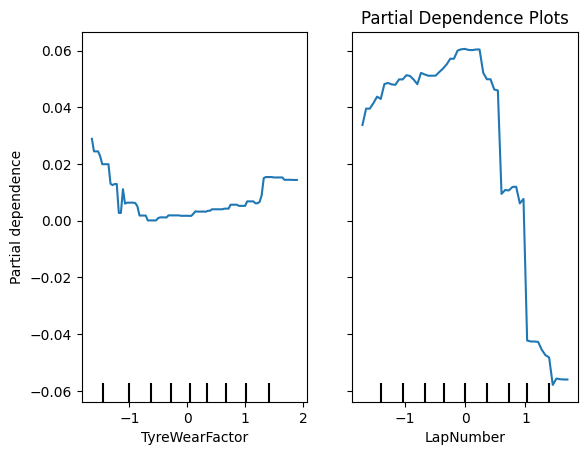

In [36]:
# Model Interpretability
import shap
from sklearn.inspection import PartialDependenceDisplay

# Install SHAP
!pip install shap

# SHAP values for XGBoost
explainer = shap.TreeExplainer(best_models['XGBoost'])
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=features)

# Partial dependence plots
plt.figure(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    best_models['XGBoost'], X_test_scaled, features=['TyreWearFactor', 'LapNumber'], feature_names=features
)
plt.title('Partial Dependence Plots')
plt.show()

**Pipeline and Deployment**

In [39]:
# Pipeline and Deployment
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
import joblib

# Define preprocessor
numeric_features = ['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
                    'StintLength', 'CumulativeDistance', 'DriverAggressiveness', 'AirTemp', 'TrackTemp', 'PrevLapTime',
                    'PrevSpeedST', 'TireLoadIndex', 'SectorTimeStd', 'PostPitLap', 'TyreWearFactor', 'TyreWearRate']
categorical_features = ['TrackStatus', 'FreshTyre', 'Compound', 'Compound_TrackTemp']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline with best model
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', best_model)  # From Cell 12
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Evaluate
y_test_pred = pipeline.predict(X_test)
print(f"Pipeline Test MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

# Save model
joblib.dump(pipeline, 'tire_degradation_model.pkl')

# Simulate real-time prediction
def predict_tire_degradation(lap_data, model):
    return model.predict(lap_data)

new_lap = X_test.iloc[:1]
prediction = predict_tire_degradation(new_lap, pipeline)
print(f"Predicted TyreDegRate: {prediction[0]:.4f} sec")

Pipeline Test MAE: 0.1968
Predicted TyreDegRate: -7.8567 sec
